## PUTSAFIRST

---------------------------------------------------------
### COMMUNITY DETECTION



Community detection in network theory is a graph partitioning problem where a group of nodes is identified such that the connections a node has within a group are more than the connections a node has outside a group.


#### Data Source



*#PutSAFirst Reply Network - Largest Component*


#### Data Transformation


Community detection techniques are typically applied to undirected networks. The direction in which a tie is sent or received is irrelevant; a connection is established as long as there is an interaction between users. The current network is therefore converted to an undirected network for the purposes of this analysis.


#### Method



Using pythons iGraph library, I apply the **Leiden** method to this community detection problem.


In [1]:
#
#import import_ipynb
import os
import pandas as pd
import numpy as np
import math
import igraph as ig
import matplotlib.colors as color
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import ipyplot
from operator import itemgetter
import random
from numpy import random as nprando
from datetime import datetime, date, time, timedelta
import pquality
from IPython.display import Image, SVG, HTML, display
#########################################################################################

##SETUP##
nprando.seed(111)
plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (12, 8)})
pd.set_option("display.max_columns",None)
pd.set_option("display.max_colwidth", None)

##FUNCTIONS##
# Sort index order
def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s

# Find date range
def date_range(date1, date2):
    for n in range(int((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
def set_vertex_community(G, communities):
    #if hasattr(G, 'community'):   
        #del(G.vs['community'])
        
    G.vs['community'] = communities
    #print(G.vs['community'])
    #print(v.index for v in G.vs)
    for v in G.vs.indices:
        #print(v)
        #Add 1 to save 0 for external edges
        G.vs[v]['community'] = G.vs[v]['community']+1
               

def set_edge_community(G):
    #Find internal edges and add their community to their attributes
    #for es in G.get_edgelist():
    for i, e_s in enumerate(G.get_edgelist()):
        #print(i, e_s)
        #for v,w in G.get_edgelist():
        if G.vs[e_s[0]]['community'] == G.vs[e_s[1]]['community']:
            #Internal edge, mark with community
            G.es[i]['community'] = G.vs[e_s[0]]['community']    
        else:
            #External edge, mark as 0
            G.es[i]['community'] = 0    


def set_vertex_color(i, r_off=1, g_off=1,b_off=1):
    #Assign a color to a vertex
    if i == 17: 
        c_hex = '#35516C'
    elif i == 18: 
        c_hex = '#4A732E'
    elif i == 35: 
        c_hex = '#D084D0'
    elif i == 14: 
        c_hex = '#ff00ff'
    else:
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)   
        c_rgb = (r,g,b)
        c_hex = color.to_hex(c_rgb)
        if c_hex == '#5e4227':
            c_hex = '#ffcb05'
        elif c_hex == '#caaf94':
            c_hex = '#ffee60'
        else:
            c_hex
    return c_hex

def set_edge_color(i, r_off=1, g_off=1,b_off=1):
    #Assign a color to a edge
    if i == 17: 
        c_hex = '#35516C'
    elif i == 18: 
        c_hex = '#4A732E'
    elif i == 35: 
        c_hex = '#D084D0'
    elif i == 14: 
        c_hex = '#ff00ff'
        #c_hex = '#4A732E'
    #if i = 22: #94e65e brown
    else: 
        r0, g0, b0 = 0, 0, 0
        n = 16
        low, high = 0.1, 0.9
        span = high - low
        r = low + span * (((i + r_off) * 3) % n) / (n - 1)
        g = low + span * (((i + g_off) * 5) % n) / (n - 1)
        b = low + span * (((i + b_off) * 7) % n) / (n - 1)   
        c_rgb = (r,g,b)
        c_hex = color.to_hex(c_rgb)
        if c_hex == '#5e4227':
            c_hex = '#ffcb05'
        elif c_hex == '#caaf94':
            c_hex = '#ffee60'
        else: 
            c_hex
    return c_hex

def sort_index(lst, rev=True):
    index = range(len(lst))
    s = sorted(index, reverse=rev, key=lambda i: lst[i])
    return s
                                            

----------------------------------------------------------------------------------------------------
#### 1. OPTIMISATION

 
To choose an optimal resolution parameter (gamma), I estimate the leiden algorithm and explore community outcomes across different values of gamma. Letting the data tell me which points are more optimal than others, I select gamma at the points in the graph where the number of communities detected reach a constant plateau or flatness.

In [2]:
#
##VARIABLES##
e_node = "putsafirst_nodes_1.csv"
e_edge = "putsafirst_edges_1.csv"

#########################################################################################

##LOAD DATA##
df_node_1 = pd.read_csv(e_node, sep=";", usecols=['id', 'label'], dtype={'id': str})
df_node_1 = df_node_1.rename(columns={"id": "id_", 'label':"label_"})
#df_node_1.describe()  
df_edge_1 = pd.read_csv(e_edge, sep=";", usecols=['source', 'target', 'weight'], dtype={'source': str, 'target': str, 'weight':int})
df_edge_1 = df_edge_1.rename(columns={"source": "source_", 'target':"target_"})
#df_edge_1.describe()

##CONVERT TO DIRECTED IGRAPH
G_ig=ig.Graph.DictList(df_node_1.to_dict('records'), df_edge_1.to_dict('records'), directed=True, vertex_name_attr='id_', edge_foreign_keys=('source_', 'target_'))
edge_strength = G_ig.strength(weights='weight',mode='all')
G_ig.vs['strength'] = edge_strength
#print("\n" + '\033[1m' + 'Directed Graph:' + '\033[0m' + "\n")
#print(ig.summary(G_ig))

##CONVERT TO UNDIRECTED IGRAPH
G_ig2=ig.Graph.DictList(df_node_1.to_dict('records'), df_edge_1.to_dict('records'), directed=False, vertex_name_attr='id_', edge_foreign_keys=('source_', 'target_'))
G_ig2.simplify(multiple=True, loops=True, combine_edges=(dict(source='first', target='first', weight=sum)))
print("\n" + '\033[1m' + 'Undirected Graph:' + '\033[0m' + "\n")
print(ig.summary(G_ig2))



Undirected Graph:

IGRAPH U-W- 7606 19003 -- 
+ attr: id_ (v), label_ (v), weight (e)
None


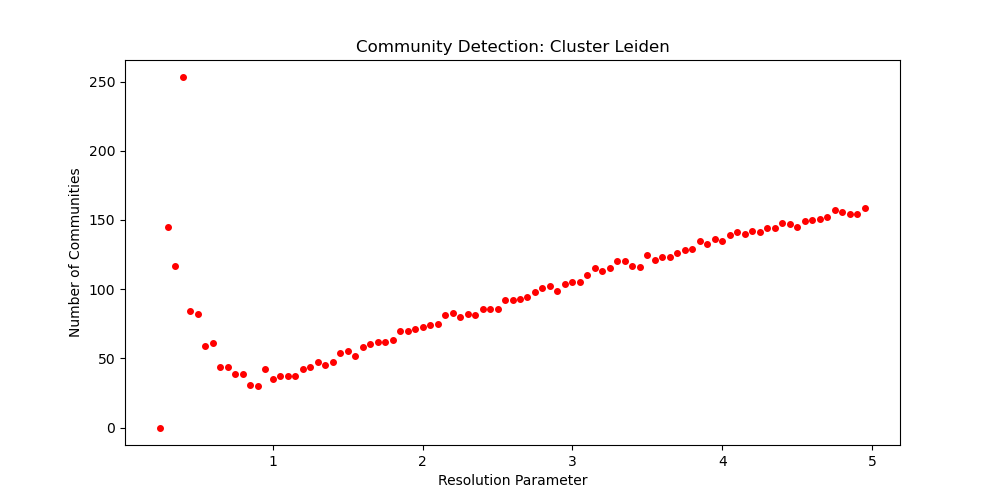

In [3]:

# Directed
#{'source': '278164594', 'target': '1114984823444201480', 'weight': 2}
#{'source': '1114984823444201480', 'target': '278164594', 'weight': 3}
# Undirected
#{'source': '1114984823444201480', 'target': '278164594', 'weight': 5}


#LEIDEN OPTIMAL RESOLUTION PARAMETER
plt.rcParams["figure.figsize"]=[10,5]
gamma = np.arange(0.25,5,0.05)
gc =[]
nc=[0]*len(gamma)
#for i in range(1,len(gamma)):
#    leiden_clust = G_ig2.community_leiden(weights=G_ig2.es["weight"], objective_function='modularity', n_iterations = 100, resolution_parameter=gamma[i]) #1 #0.6 #0.05 #0.01
#    leiden_com = len(leiden_clust)

#    nc[i] = leiden_com
#    gc.append(gamma[i])

#plt.plot(gamma,nc,'ro',markersize=4)
#plt.title('Community Detection: Cluster Leiden')
#plt.xlabel('Resolution Parameter')
#plt.ylabel('Number of Communities')
#plt.savefig("putsafirst_optim_ld_2.png")
#plt.show()
Image(filename="putsafirst_optim_ld_2.png",  width = "650")

------------------------------------------------------
#### 2. DETECTION



The point of optimised modularity is less clear in this case. Setting gamma at the default resolution parameter of gamma=1, I detect 35 communities with a modularity of 0.47. The detected communities are visualised below along with descriptions of the top 3 largest communities (by weighted degree).

In [3]:
#

#COMMUNITY SELECTION
#print("\n" + '\033[1m' + "Leiden (Optimum)" + '\033[0m')
print("--------\n")
gamma=1
optimum_clust = G_ig2.community_leiden(weights=G_ig2.es["weight"], objective_function='modularity', n_iterations=100, resolution_parameter=gamma) #1 #0.6 #0.05 #0.01
print('\033[1m' + 'Communinities:' + '\033[0m')
print(len(optimum_clust)) #39 #34
optimum_mem = optimum_clust.membership
optimum_mod = G_ig2.modularity(optimum_mem, weights=G_ig2.es["weight"])
print("\n" + '\033[1m' + 'Modularity:' + '\033[0m')
print(optimum_mod) #0.8523986065565808 #0.8441848638707548
#print("\n--------")

#G_ig.vs['optimum_ld'] = optimum_mem

--------

Communinities:
35

Modularity:
0.4629748237652841


In [4]:
#
# Leiden (Optimal) Plot
'''set_vertex_community(G_ig, optimum_mem)
G_ig.vs['community_op'] = G_ig.vs['community']
set_edge_community(G_ig)
G_ig.es['community_op'] = G_ig.es['community']
vcolor_lst = [set_vertex_color(G_ig.vs[v]['community_op']) for v in G_ig.vs.indices]
G_ig.vs['hex_op'] = vcolor_lst
ecolor_lst = [set_edge_color(G_ig.es[i]['community_op']) for i, e_s in enumerate(G_ig.get_edgelist())]
G_ig.es['hex_op'] = ecolor_lst'''


print("\n" + "--------" + "\n" + '\033[1m' + 'PutSAFirst Communities:' + '\033[0m' + "\n")
display(SVG(filename="putsafirst_comm_op_4.svg"))


--------
PutSAFirst Communities:



In [5]:
#
#
#Leiden (Optimal) Community Degree and Density
e_vcom = "putsafirst_vcomm_1_a.csv"
e_ecom = "putsafirst_ecomm_1_a.csv"
#########################################################################################

df_vcomm_1 = pd.read_csv(e_vcom, sep=",", dtype={'Id': str})
df_vcomm_1 = df_vcomm_1.rename(columns={"v_id_": "id", 'label_':"label",'v_strength':"strength",'v_community_op':"community_op"})
#df_node_1.describe()  
df_ecomm_1 = pd.read_csv(e_ecom, sep=",", dtype={'Source': str, 'Target': str, 'Weight':int})
df_ecomm_1 = df_ecomm_1.rename(columns={"e_source_": "source_", 'e_target':"target_", 'Weight':"weight",'e_community_op':"community_op"})
#df_edge_1.describe()

##CONVERT TO UNDIRECTED IGRAPH
G_ig1=ig.Graph.DictList(df_vcomm_1.to_dict('records'), df_ecomm_1.to_dict('records'), directed=False, vertex_name_attr='id', edge_foreign_keys=('source_', 'target_'))
com_lst = set(df_vcomm_1["community_op"].to_list())
#print(com_lst)

##CONVERT TO SUBGRAPH
siz_c_lst = []
den_c_lst = []
deg_c_lst = []
avg_deg_c_lst = []

for com in com_lst:
    df_vc = df_vcomm_1.loc[df_vcomm_1["community_op"]==com]
    df_ec = df_ecomm_1.loc[df_ecomm_1["community_op"]==com]
    G_ig_c=ig.Graph.DictList(df_vc.to_dict('records'), df_ec.to_dict('records'), directed=False, vertex_name_attr='id', edge_foreign_keys=('source_', 'target_'))

#########################################################################################


    #size
    siz_c = G_ig_c.vcount()
    siz_c_lst.append(siz_c)
    #print("\n" + '\033[1m' + "Highest Total Degree" + '\033[0m')   
    # density
    den_c = G_ig_c.density()
    den_c_lst.append(den_c)
    # degree
    deg_c = G_ig_c.strength(weights='weight',mode='all')
    tot_deg_c = np.sum(deg_c)
    deg_c_lst.append(tot_deg_c)
    avg_deg_c = np.mean(deg_c)
    avg_deg_c_lst.append(avg_deg_c)
    #print(siz_c_lst)
    #print(den_c_lst)
    #print(deg_c_lst)

    max_siz_c = sort_index(siz_c_lst)
    max_den_c = sort_index(den_c_lst)
    max_deg_c = sort_index(deg_c_lst)
    max_avg_deg_c = sort_index(avg_deg_c_lst)
    #print(sort_index(siz_c_lst))
    #print(sort_index(den_c_lst))
    #print(sort_index(deg_c_lst))

    

print("\n" + "--------" + "\n" + '\033[1m' + "Top 3 Weighted Degree Communities: "  +  '\033[0m')
#print("--------------------------------")
for i, c in enumerate(max_deg_c[:3]):
    com_ = c+1
    #com1 = G_ig.vs.select(label="PieterDuToit")["community_op"]
    print("--------------------------------")
    print("\n" + "--------" + "\n" + '\033[1m' + "Community " + str(i+1) + ":" + '\033[0m')
    print("--------")
    #print("Community " + str(i+1))
    #print("--------------------------------")
    print("\n" + '\033[1m' +"Size:" + '\033[0m') 
    print(siz_c_lst[c])
    print("\n" + '\033[1m' +"Density:" + '\033[0m')
    print(den_c_lst[c])
    print("\n" + '\033[1m' +"Average Degree:" + '\033[0m')
    print(format(avg_deg_c_lst[c],".2f"))
    print("\n" + '\033[1m' +"Total Degree:" + '\033[0m')
    print(int(deg_c_lst[c]))
    print("\n" + '\033[1m' +"Members(10*):" + '\033[0m')
    for i, v1 in enumerate(sorted(G_ig1.vs.select(community_op=com_), key=lambda x:x['strength'], reverse=True)[:10]):
        print(i, v1["label"])

'''
#Leiden (Optimal) Community Degree and Density
#size
siz_c_lst = optimum_clust.sizes()
#print("\n" + '\033[1m' + "Highest Total Degree" + '\033[0m')
den_c_lst = []
deg_c_lst = []
avg_deg_c_lst = []
for c in range(0,len(optimum_clust)):
    # create subgraph
    G_ig_c = optimum_clust.subgraph(c)
    # density
    den_c = G_ig_c.density()
    den_c_lst.append(den_c)
    # degree
    deg_c = G_ig_c.strength(weights='weight',mode='all')
    tot_deg_c = np.sum(deg_c)
    deg_c_lst.append(tot_deg_c)
    avg_deg_c = np.mean(deg_c)
    avg_deg_c_lst.append(avg_deg_c)
#print(siz_c_lst)
#print(den_c_lst)
#print(deg_c_lst)

max_siz_c = sort_index(siz_c_lst)
max_den_c = sort_index(den_c_lst)
max_deg_c = sort_index(deg_c_lst)
max_avg_deg_c = sort_index(avg_deg_c_lst)
#print(sort_index(siz_c_lst))
#print(sort_index(den_c_lst))
#print(sort_index(deg_c_lst))

print("\n" + "--------" + "\n" + '\033[1m' + "Top 3 Largest Degree Communities: "  +  '\033[0m')
#print("--------------------------------")
for i, c in enumerate(max_deg_c[:3]):
    com = c+1
    #com1 = G_ig.vs.select(label="PieterDuToit")["community_op"]
    print("--------------------------------")
    print("\n" + "--------" + "\n" + '\033[1m' + "Community " + str(i+1) + ":" + '\033[0m')
    print("--------")
    print("\n" + '\033[1m' +"Size:" + '\033[0m') 
    print(siz_c_lst[c])
    print("\n" + '\033[1m' +"Density:" + '\033[0m')
    print(den_c_lst[c])
    print("\n" + '\033[1m' +"Average Degree:" + '\033[0m')
    print(int(avg_deg_c_lst[c]))
    print("\n" + '\033[1m' +"Total Degree:" + '\033[0m')
    print(int(deg_c_lst[c]))
    print("\n" + '\033[1m' +"Members(10*):" + '\033[0m')
    for i, v1 in enumerate(sorted(G_ig.vs.select(community_op=com), key=lambda x:x['strength'], reverse=True)[:10]):
        print(i, v1["label"])

#print("\n" + "--------")  
print("\n" + "--------------------------------")
print("*Top 10 members in community with the largest *weighted degree*.")
'''

print("--------------------------------")
print("*Top 10 highest degree in community.")


--------
Top 3 Weighted Degree Communities: 
--------------------------------

--------
Community 1:
--------

Size:
1422

Density:
0.0019092752771121544

Average Degree:
4.35

Total Degree:
6182

Members(10*):
0 MEB40122141
1 nan
2 Maps_pj
3 landback_
4 Custoza1
5 nellyngwenya7
6 Khadijahhosana
7 Nkweeng1
8 MarioKhumalo
9 happyerics
--------------------------------

--------
Community 2:
--------

Size:
866

Density:
0.0018288857146671294

Average Degree:
1.98

Total Degree:
1712

Members(10*):
0 WolfDen12427788
1 Light50995046
2 News24
3 MbalulaFikile
4 siza_mhayise
5 Pheaga1
6 VictoriaAfrica9
7 ssoshaah
8 LvovoSA
9 alfred_cabonena
--------------------------------

--------
Community 3:
--------

Size:
530

Density:
0.00363804972001284

Average Degree:
2.77

Total Degree:
1468

Members(10*):
0 peezyjr
1 CyrilRamaphosa
2 MYANC
3 PresidencyZA
4 SAPoliceService
5 tito_mboweni
6 ewnupdates
7 AlomNyama
8 GovernmentZA
9 Sibusisok16614
--------------------------------
*Top 10 highest degre

In [6]:
#
#Vertex attributes
df_vcomm = G_ig.get_vertex_dataframe()
#df_vcomm = df_vcomm.loc[:,['id','strength','community_op','hex_op']]

#Edge attributes
df_ecomm = G_ig.get_edge_dataframe()
#df_ecomm = df_ecomm.loc[:,['source_','target_','community_op','hex_op']]

G_ig2_c=ig.Graph.DictList(df_vcomm.to_dict('records'), df_ecomm.to_dict('records'), directed=True, vertex_name_attr='id_', edge_foreign_keys=('source_', 'target_'))
G_ig2_c.write_graphml("putsafirst_comm_3.graphml")

df_vcomm = df_vcomm.rename(columns={"id_": "id", 'label_':"label"})
#df_vcomm.to_csv("putsafirst_vcomm_1.csv", sep=";",encoding='utf-8',  index=False)
df_ecomm = df_ecomm.rename(columns={"source_": "source", 'target_':"target"})
#df_ecomm.to_csv("putsafirst_ecomm_1.csv", sep=";",encoding='utf-8',  index=False)

#find community degree
#plot density degree

------------------------------------------------------------------------
#### 3. EVALUATION


Using various pair counting scores, I compare community outcomes of the leiden model at gamma=1 and gamma=2.5, and compare the leiden model at gamma=1 and the louvain model. 


#### 3.1. Leiden (Gamma=1) vs Leiden (Gamma=2.5)

In [7]:
#
#COMMUNITY SELECTION
#print("\n" + '\033[1m' + "Leiden (Optimum)" + '\033[0m')
#print("\n"+"--------"+"\n"+)
#print("\n" + "--------" + "\n" + '\033[1m' + "Model Comparison: "  +  '\033[0m')
#print("--------------------------------")
print("--------" + "\n" + '\033[1m' + "Leiden (Gamma=2.5)" + '\033[0m')
print("--------------------------------")
gamma=2.5
optimum_clust_2 = G_ig2.community_leiden(weights=G_ig2.es["weight"], objective_function='modularity', n_iterations = 100, resolution_parameter=gamma) #1 #0.6 #0.05 #0.01
print("\n"+'\033[1m' + 'Communinities:' + '\033[0m')
print(len(optimum_clust_2)) #39 #34
optimum_mem_2 = optimum_clust_2.membership
optimum_mod_2 = G_ig2.modularity(optimum_mem_2, weights=G_ig2.es["weight"])
print("\n" + '\033[1m' + 'Modularity:' + '\033[0m')
print(optimum_mod_2) #0.8523986065565808 #0.8441848638707548
#print("\n--------")
#G_ig.vs['optimum_ld'] = optimum_mem#

--------
Leiden (Gamma=2.5)
--------------------------------

Communinities:
90

Modularity:
0.4388048823643757


In [8]:
# Leiden - Louvain
lele_vi = optimum_clust.compare_to(optimum_clust_2, method='nvi', remove_none=False)
lele_adjr = optimum_clust.compare_to(optimum_clust_2, method='adjusted_rand', remove_none=False)
lele_nmi = optimum_clust.compare_to(optimum_clust_2, method='nmi', remove_none=False)
print("\n" + '\033[1m' + "Comparison Scores:" + '\033[0m')
print("--------" + "\n")
print('\033[1m' + 'Variation of Information:' + '\033[0m')
print(lele_vi)
print("\n" + '\033[1m' + 'Adjusted Rand:' + '\033[0m')
print(lele_adjr)
print("\n" + '\033[1m' + 'Normalized Mutual Information:' + '\033[0m')
print(lele_nmi)
print("--------------------------------")


Comparison Scores:
--------

Variation of Information:
0.5960006524376178

Adjusted Rand:
0.2732328442840795

Normalized Mutual Information:
0.5960006524376178
--------------------------------


In [9]:
df_vcomm_1['community_op2']=optimum_mem_2
df_lele = pd.crosstab(index=df_vcomm_1['community_op'], columns=df_vcomm_1['community_op2'])
#print(df_lele)

#### 3.2. Leiden (Gamma=0.8) vs Louvain

In [10]:
#Louvain Method
ig_louvain_clust = G_ig2.community_multilevel(weights="weight")
#print("\n" + '\033[1m' + "Stats" + '\033[0m')
print("--------" + "\n" + '\033[1m' + "Louvain" + '\033[0m')
print("--------------------------------")
print("\n"+'\033[1m' + 'Communinities:' + '\033[0m')
print(len(ig_louvain_clust)) #42 #38 #39 #10
#ig_louvain_hist = ig_louvain_clust.size_histogram
#ig.plot(ig_louvain_hist,"{}".format(gpath) + x + "_louvain_hist_1.png")
ig_louvain_mem = ig_louvain_clust.membership
ig_louvain_mod = G_ig2.modularity(ig_louvain_mem, weights=G_ig2.es["weight"])
print("\n" + '\033[1m' + 'Modularity:' + '\033[0m')
print(ig_louvain_mod) #0.8511943740418598 #0.8428720537220518 #0.4548224731375923 #0.6868678459937566
#print("\n--------")
#G_ig.vs['community_ln'] = ig_louvain_mem


--------
Louvain
--------------------------------

Communinities:
36

Modularity:
0.4555789102607928


In [11]:
# Leiden - Louvain
lelo_vi = optimum_clust.compare_to(ig_louvain_clust, method='nvi', remove_none=False)
lelo_adjr = optimum_clust.compare_to(ig_louvain_clust, method='adjusted_rand', remove_none=False)
lelo_nmi = optimum_clust.compare_to(ig_louvain_clust, method='nmi', remove_none=False)
print("\n" + '\033[1m' + "Comparison Scores:" + '\033[0m')
print("--------" + "\n")
print('\033[1m' + 'Variation of Information:' + '\033[0m')
print(lelo_vi)
print("\n" + '\033[1m' + 'Adjusted Rand:' + '\033[0m')
print(lelo_adjr)
print("\n" + '\033[1m' + 'Normalized Mutual Information:' + '\033[0m')
print(lelo_nmi)
print("--------------------------------")


Comparison Scores:
--------

Variation of Information:
0.5419488041481584

Adjusted Rand:
0.39619142893310055

Normalized Mutual Information:
0.5419488041481584
--------------------------------


In [12]:
df_vcomm_1['community_lo']=ig_louvain_mem
df_lelo = pd.crosstab(index=df_vcomm_1['community_op'], columns=df_vcomm_1['community_lo'])
#print(df_lelo)

--------------------------------------------------------------------------
#### 4. SUMMARY




In this section, I use community detection methods to identify densely connected groups and communities present in the #PutSAFirst twitter reply network.

When searching for optimum modularity, I find the resolution parameter robust around gamma=1 and gamma=2.5. I detect 35 and 90 communities with a modularity score of 0.46 and 0.44 at these points, respectively. Similarly, using the louvain method, 37 communities are detected with a modularity score of 0.843. The coincidence scores from the evaluation and the modularity scores, which are below the 0.7 threshold, are all a sign of a poorly partitioned network. Furthermore, given the large number of communities detected, a reasonable or meaningful interpretation is difficult. In other words, attemping to characterise all 35 communities or predict each of their behaviour and influence in the discourse based on their memberships will unliklely result in an intuitive outcome. 

To atleast get some sense of the communities detected, I examine the sizes, densities, and degrees of the top 3 largest communities as well as the top 10 members (sorted by *weighted degree*) assigned to each of the 3 communities. Going by the users and tweet content, I find **Community 1** to contain users in strong support of the #PutSAFirst movement, with user **MEB40122141** leading the charge. The second largest contributer to this community is listed as **nan**, which means *none* or missing. For some reason this account's username has been left out of the data set, entirely. If it were not for their username being mentioned in other users tweets as **mudzu_thabe**, it would not have been possible to identify them by name. There is also no record of them having sent any tweets. In fact, their significant contribution to the discourse is only a result of large numbers of users replying to their (ommitted) tweets. Currently the user's page has been suspended, which may be the reason for the missing data (especially if they were suspended prior to the data being extracted). 

For interest, this detection outcome puts the **Lerato_Pillay** account at the top of list in the 4th largest community by total weighted degree.

In the next section, I classify users by the positions or roles they play within the discourse based on their patterns of interactions and other network features.
